<a href="https://colab.research.google.com/github/matEOTCH/Model_IA_TB_Detection/blob/main/TB_Cough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Modelo IA para detección de Tuberculosis

Members:
 - Lopez Medina Sebastian
 - Nieto Espinoza Brajan Esteban
 - Tapia Chasquibol Mateo

 ----
 The objective of this project is to classify patients as either Tuberculosis-positive or Healthy, using only the acoustic signal of the patient’s cough.

To achieve this, the group applies audio signal processing techniques to extract representative features from cough recordings and evaluates several machine learning classification models, including:

Logistic Regression

Support Vector Machines (SVM)

k-Nearest Neighbors (KNN)

Decision Trees (DT)

These models are trained and compared using multiple evaluation metrics such as precision, recall, F1-score, ROC curves, and AUC, allowing a comprehensive performance assessment.

The goal is to identify the most robust and accurate model for Tuberculosis detection from cough audio signals, ensuring reliable classification while considering model stability and generalization performance.

In [12]:
# ============================================
# 1  Librerias y datos
# ============================================
# -------------------------------------------
# 1.1 Clonar repositorio
# -------------------------------------------
!git clone https://github.com/matEOTCH/Model_IA_TB_Detection.git
%cd Mlearning
# -------------------------------------------
# 1.2 Librerías
# -------------------------------------------
import os
import re
import math
import random
import itertools
#  Librerías extras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt
import librosa
import pywt
from scipy.signal import butter, filtfilt
# scikit-learn
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

fatal: destination path 'Model_IA_TB_Detection' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'Mlearning'
/content/Model_IA_TB_Detection


## Audio Preprocessing y Extracción de Features

**Puntos clave a tener en cuenta:**

1. **`normalize_audio(audio)`**  
   - Escala el pico máximo de la señal a 0.99.  
   - Añade un pequeño epsilon (`1e-6`) para evitar división por cero.  

2. **`remove_silence(audio, sr, top_db=50)`**  
   - Usa `librosa.effects.split` para identificar segmentos con energía por encima de `top_db`.  
   - Reconstruye el audio concatenando solo los intervalos activos (sin silencio).

3. **`segment_audio(audio, sr, duration=1.5, hop=0.75)`**  
   - Crea fragmentos superpuestos de longitud fija (`duration` segundos) con un salto (`hop`) entre inicios.  
   - Calcula `frame_length = duration * sr` y `hop_length = hop * sr`.  
   - Genera una lista de segmentos para procesamiento batch.

4. **`extract_features(segment, sr)`**  
   - Calcula **128 MFCCs** con `n_fft=512` y `hop_length=256`, y luego obtiene su valor medio.  
   - Calcula la **tasa de cruce por cero** (zero-crossing rate) y toma su media.  
   - Concatena ambos para un vector final de características.

5. **Observación sobre dimensiones**  
   - Aunque el docstring menciona “vector de 125 dimensiones”, la concatenación de 128 MFCCs más 1 valor de ZCR da **129 dimensiones**. Comprueba que downstream acepte este tamaño.

In [16]:
# ============================================
# 2  Funciones para  de Procesamiento de Audio
# ============================================

def normalize_audio(audio):
    """Normaliza el pico máximo a 0.99."""
    peak = np.max(np.abs(audio)) + 1e-6
    return audio / peak * 0.99



def remove_silence(audio, sr, top_db=50):
    """Recorta silencios; si no hay intervalos detectados, devuelve el audio original."""
    intervals = librosa.effects.split(audio, top_db=top_db)
    if len(intervals) == 0:
        return audio
    return np.concatenate([audio[s:e] for s, e in intervals])


def segment_audio(audio, sr, duration=1.5, hop=0.75):
    """Divide en fragmentos superpuestos; si el audio es corto, devuelve 1 segmento."""
    fl = int(duration * sr)
    hl = int(hop * sr)

    if audio is None or len(audio) == 0:
        return []

    if len(audio) <= fl:
        return [audio]  # devuelve el audio completo como 1 segmento

    return [audio[i:i+fl] for i in range(0, len(audio)-fl+1, hl)]


def extract_features(segment, sr):
    """Calcula MFCCs (128) y zero‐crossing rate (1) y devuelve vector de 125 dims."""
    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=128, n_fft=512, hop_length=256)
    zcr   = librosa.feature.zero_crossing_rate(segment)
    return np.hstack([mfccs.mean(axis=1), zcr.mean()])

## Creación de DataFrame de Features

- Recorre carpetas `Negative`, `Positive` y `Unknown`, cargando sólo `.wav`.  
- Normaliza audio y elimina silencios antes de segmentar.  
- Segmenta en ventanas superpuestas, extrae 128 MFCCs + ZCR por segmento.  
- Genera filas `[filename, label, mfcc…, zcr]`, filtra `Unknown`, no se tomara en cuenta como una categoria adicional y mapea tiquetas a 0/1.  


In [17]:
# ============================================
# 3  Generación de registros y DataFrame
# ============================================

label_map = {
    'CS_H_individuals': 'Negative',
    'CS_TB_individuals': 'Positive'
}

base_path = '/content/Model_IA_TB_Detection/data/Dataset_TB_Cough'
records = []

# DEBUG: validar carpetas
for folder_name in label_map.keys():
    folder = os.path.join(base_path, folder_name)
    print(folder, "EXISTS:", os.path.isdir(folder),
          "| files:", len(os.listdir(folder)) if os.path.isdir(folder) else "NA")

for folder_name, label in label_map.items():
    folder = os.path.join(base_path, folder_name)

    for fname in os.listdir(folder):
        if not fname.lower().endswith('.wav'):
            continue

        path = os.path.join(folder, fname)

        try:
            audio, sr = librosa.load(path, sr=16000)
        except Exception as e:
            print("ERROR loading:", path, e)
            continue

        audio = normalize_audio(audio)
        audio = remove_silence(audio, sr)

        segments = segment_audio(audio, sr)
        if len(segments) == 0:
            continue

        for seg in segments:
            feats = extract_features(seg, sr)
            records.append([fname, label] + feats.tolist())

print("TOTAL records:", len(records))

cols = ['filename', 'label'] + [f'mfcc_{i}' for i in range(128)] + ['zcr']
df = pd.DataFrame(records, columns=cols)

mapping = {'Negative': 0, 'Positive': 1}
df['label'] = df['label'].map(mapping)

print(df.head())
print("DF shape:", df.shape)
print("Label counts:\n", df['label'].value_counts(dropna=False))


/content/Model_IA_TB_Detection/data/Dataset_TB_Cough/CS_H_individuals EXISTS: True | files: 230
/content/Model_IA_TB_Detection/data/Dataset_TB_Cough/CS_TB_individuals EXISTS: True | files: 226
TOTAL records: 456
   filename  label      mfcc_0     mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
0  0238.wav      0 -121.097214  75.512573 -65.000557  -0.756095 -33.178593   
1  0365.wav      0 -128.758972  47.283520 -68.164833 -30.669525  -6.407839   
2  0391.wav      0 -220.315521  84.660393 -64.111702  13.951018 -18.251617   
3  0273.wav      0 -228.692123  80.689217 -52.392338  -6.228627 -27.431280   
4  0456.wav      0 -258.580048  76.886925   5.883116  22.456272  -9.016497   

      mfcc_5     mfcc_6     mfcc_7  ...  mfcc_119  mfcc_120  mfcc_121  \
0 -18.348516 -35.549892 -38.923122  ... -1.327373 -2.088029 -0.591155   
1 -10.491783 -31.492798  -9.880319  ... -0.405228 -0.367802 -0.722054   
2   1.051687 -38.112587 -22.215155  ... -1.627688 -0.565703 -1.292322   
3  15.665348 -23.989092 -25

## Preparación de Conjuntos de Entrenamiento y Prueba

- Separa **features** (`X`) y **labels** (`y`) en `train_df` y `test_df`.  
- Elimina la columna `label` de `X_train` y `X_test`.  
- Muestra dimensiones de cada set y conteo de clases (`value_counts`).  


In [18]:
# ============================================
# 5  Preparar X e y para entrenamiento y prueba
# ============================================

# 1) Separar X e y
X = df.drop(columns=['filename', 'label'])
y = df['label']

# 2) Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3) Validación rápida
print("Train:", X_train.shape, y_train.value_counts().to_dict())
print("Test :", X_test.shape,  y_test.value_counts().to_dict())

Train: (364, 129) {0: 184, 1: 180}
Test : (92, 129) {1: 46, 0: 46}


## Configuración de Modelos y Búsqueda de Hiperparámetros

- **Pipelines**  
  - Escalado con `StandardScaler` para regresión logística, SVM y KNN; árbol de decisión sin escalado.  
  - Todos los clasificadores usan `class_weight='balanced'` salvo KNN.

- **Modelos incluidos**  
  - **LogReg**: regresión logística (solver lbfgs, iteraciones 1000)  
  - **SVM**: máquina de vectores de soporte con núcleo RBF (probabilidad desactivada)  
  - **DT**: árbol de decisión  
  - **KNN**: k vecinos más cercanos

- **Grillas de hiperparámetros**  
  - **LogReg**: búsqueda de constantes de regularización `C` (valores de 0.01 a 100)  
  - **SVM**: `C` (0.1–10) y `gamma` (‘scale’ o 0.1)  
  - **DT**: profundidades de 2 a 100 (o ilimitada) y muestras mínimas por hoja 1–10  
  - **KNN**: número de vecinos entre 2 y 30


In [20]:
# -------------------------------------------
# 6. Definición de pipelines y grids
# -------------------------------------------
base_pipes = {
    'LogReg': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1_000, solver='lbfgs',
                                   class_weight='balanced', random_state=42))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', class_weight='balanced', probability=False,
                    random_state=42))
    ]),
    'DT': Pipeline([
        ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())   # KNN no usa class_weight
    ])
}

param_grids = {
    'LogReg': {'clf__C': [0.01, 0.1, 0.5, 0.6, 0.7, 1, 10, 100]},
    'SVM'   : {'clf__C': [0.1, 1, 1.5, 10],
               'clf__gamma': ['scale', 0.01, 0.1, 1]},
    'DT'    : {'clf__max_depth': [None, 5, 10, 20],
               'clf__min_samples_leaf': [2, 3, 5]},
    'KNN'   : {'clf__n_neighbors': [2, 3, 4, 10, 20, 30]}
}

## Evaluación con Grid Search y Validación Cruzada

- Itera sobre cada pipeline en `base_pipes`.  
- Usa `StratifiedKFold(n_splits=10, shuffle=True)` como CV interno.  
- Configura `GridSearchCV` con:
  - `scoring='f1_weighted'`  
  - `n_jobs=-1` para paralelizar  
  - `refit=True` para conservar el mejor modelo.  
- Ajusta (`fit`) en `X_train`, `y_train` y almacena el mejor estimador en `best_estimators[name]`.  
- Imprime el mejor `f1` obtenido y los parámetros óptimos (`best_params_`).  


In [21]:
# ============================================================
# 7. GRID SEARCH + BOOTSTRAP (OOB) - VERSION CORREGIDA Y ROBUSTA
# ============================================================

import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import resample
from sklearn.base import clone

# -------------------------
# CONFIGURACIÓN
# -------------------------
B = 10  # número de remuestreos bootstrap por combinación (sube a 20-50 si tienes tiempo)
min_oob = 20  # mínimo de muestras OOB para considerar válido el bootstrap
max_oob_tries = 10  # reintentos si sale OOB muy pequeño

# Guarda el mejor resultado por modelo
best_results = {}     # name -> dict con best_score, best_params, etc.
best_estimators = {}  # name -> estimador final entrenado con best_params sobre TODO el train

# -------------------------
# FUNCIÓN DE EVALUACIÓN OOB
# -------------------------
def eval_oob_f1_weighted(pipe, X_train, y_train, b, min_oob=20, max_tries=10):
    """
    Hace 1 bootstrap. Entrena con muestra bootstrap y evalúa en OOB.
    Reintenta si OOB queda vacío o muy pequeño.
    Devuelve (prec, rec, f1) o None si no se pudo.
    """
    for t in range(max_tries):
        X_bs, y_bs = resample(
            X_train, y_train,
            replace=True,
            random_state=42 + b + 1000*t
        )

        # OOB = índices NO seleccionados en el bootstrap
        oob_mask = ~X_train.index.isin(X_bs.index)
        X_oob, y_oob = X_train[oob_mask], y_train[oob_mask]

        if y_oob.shape[0] < min_oob:
            continue

        pipe.fit(X_bs, y_bs)
        y_pred = pipe.predict(X_oob)

        prec, rec, f1, _ = precision_recall_fscore_support(
            y_oob, y_pred,
            average='weighted',
            zero_division=0
        )
        return (prec, rec, f1)

    return None


# -------------------------
# BÚSQUEDA POR MODELO
# -------------------------
for name, base_pipe in base_pipes.items():
    print(f"\nModelo: {name}")
    print("-" * 80)

    best_score = -np.inf
    best_params = None
    best_summary = None

    # Recorremos combinaciones de hiperparámetros
    for params in ParameterGrid(param_grids[name]):
        # Importante: clonar para no contaminar estado entre params
        pipe = clone(base_pipe)
        pipe.set_params(**params)

        boot_metrics = []
        for b in range(B):
            m = eval_oob_f1_weighted(pipe, X_train, y_train, b, min_oob=min_oob, max_tries=max_oob_tries)
            if m is not None:
                boot_metrics.append(m)

        # Si no hubo bootstrap válido, saltamos combinación
        if len(boot_metrics) == 0:
            continue

        arr = np.array(boot_metrics)  # shape: (n_boot_valid, 3)
        mean_prec, mean_rec, mean_f1 = arr.mean(axis=0)
        std_prec, std_rec, std_f1 = arr.std(axis=0)

        print(f"params = {params}")
        print(f"f1  = {mean_f1:.3f} ± {std_f1:.3f} | prec = {mean_prec:.3f} ± {std_prec:.3f} | rec = {mean_rec:.3f} ± {std_rec:.3f}")

        # Actualizamos mejor según F1 promedio
        if mean_f1 > best_score:
            best_score = mean_f1
            best_params = params
            best_summary = {
                "mean_f1": float(mean_f1), "std_f1": float(std_f1),
                "mean_prec": float(mean_prec), "std_prec": float(std_prec),
                "mean_rec": float(mean_rec), "std_rec": float(std_rec),
                "n_boot_valid": int(len(boot_metrics))
            }

    # Si no encontró nada válido, reportamos y seguimos
    if best_params is None:
        print("No se encontró ninguna combinación válida (OOB insuficiente).")
        continue

    print("-" * 80)
    print(f"✓ Mejor f1 medio = {best_score:.3f} con params = {best_params}")
    print(f"  Detalle: {best_summary}")

    # -------------------------
    # ENTRENAMIENTO FINAL
    # -------------------------
    final_model = clone(base_pipe).set_params(**best_params)
    final_model.fit(X_train, y_train)

    best_results[name] = {
        "best_score_f1_weighted": float(best_score),
        "best_params": best_params,
        "bootstrap_summary": best_summary
    }
    best_estimators[name] = final_model

# -------------------------
# RESUMEN FINAL
# -------------------------
print("\n" + "=" * 80)
print("RESUMEN MEJORES MODELOS (según F1 weighted OOB bootstrap)")
print("=" * 80)
for name, info in best_results.items():
    print(f"{name}: f1={info['best_score_f1_weighted']:.3f} | params={info['best_params']} | boot_valid={info['bootstrap_summary']['n_boot_valid']}")



Modelo: LogReg
--------------------------------------------------------------------------------
params = {'clf__C': 0.01}
f1  = 0.910 ± 0.026 | prec = 0.911 ± 0.024 | rec = 0.910 ± 0.026
params = {'clf__C': 0.1}
f1  = 0.918 ± 0.016 | prec = 0.921 ± 0.015 | rec = 0.918 ± 0.016
params = {'clf__C': 0.5}
f1  = 0.914 ± 0.024 | prec = 0.917 ± 0.024 | rec = 0.914 ± 0.024
params = {'clf__C': 0.6}
f1  = 0.915 ± 0.022 | prec = 0.918 ± 0.022 | rec = 0.915 ± 0.022
params = {'clf__C': 0.7}
f1  = 0.915 ± 0.022 | prec = 0.918 ± 0.022 | rec = 0.915 ± 0.022
params = {'clf__C': 1}
f1  = 0.913 ± 0.025 | prec = 0.916 ± 0.024 | rec = 0.913 ± 0.025
params = {'clf__C': 10}
f1  = 0.914 ± 0.022 | prec = 0.917 ± 0.021 | rec = 0.914 ± 0.022
params = {'clf__C': 100}
f1  = 0.909 ± 0.022 | prec = 0.910 ± 0.022 | rec = 0.909 ± 0.022
--------------------------------------------------------------------------------
✓ Mejor f1 medio = 0.918 con params = {'clf__C': 0.1}
  Detalle: {'mean_f1': 0.9182143308667484, 'std_f1

## Evaluación en Conjunto de Prueba

- Para cada modelo óptimo en `best_estimators`:  
  - Predice etiquetas sobre `X_test`.  
  - Calcula **precision**, **recall** y **f1 ponderado**.  
- Almacena los resultados en una lista de diccionarios con claves `model`, `precision`, `recall`, `f1`.  
- Convierte la lista en un DataFrame, lo indexa por `model` y redondea a 3 decimales.  
- Imprime la tabla resultante en formato Markdown (`to_markdown()`).  


In [ ]:
# -------------------------------------------
# 8. Evaluación en test con los mejores estimadores
# -------------------------------------------
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

results_test = []

for name, est in best_estimators.items():
    # 0) Ajustamos el pipeline completo sobre X_train, y_train
    est.fit(X_train, y_train)

    # 1) Predecimos sobre X_test
    y_pred = est.predict(X_test)

    # 2) Calculamos precision, recall y f1 ponderado
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall    = recall_score(   y_test, y_pred, average='weighted', zero_division=0)
    f1        = f1_score(       y_test, y_pred, average='weighted', zero_division=0)

    results_test.append({
        'model':     name,
        'precision': precision,
        'recall':    recall,
        'f1':        f1,
    })

df_test = pd.DataFrame(results_test).set_index('model').round(3)
print(df_test.to_markdown())


| model   |   precision |   recall |    f1 |
|:--------|------------:|---------:|------:|
| LogReg  |       0.873 |    0.76  | 0.805 |
| SVM     |       0.916 |    0.926 | 0.904 |
| DT      |       0.866 |    0.87  | 0.868 |
| KNN     |       0.909 |    0.92  | 0.89  |


In [22]:
# ============================================================
# 8. Evaluación en test con los mejores estimadores
#    (asegura usar los mejores hiperparámetros encontrados)
# ============================================================

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pandas as pd

# IMPORTANTE:
# Debes tener esto definido desde tu Grid+Bootstrap:
# - best_estimators: dict con pipelines (clonados)
# - best_params_by_model: dict con los mejores params por modelo
#   Ej: best_params_by_model['SVM'] = {'clf__C': 1.5, 'clf__gamma': 'scale'}

results_test = []

for name, est in best_estimators.items():

    # 0) Aplicar los mejores hiperparámetros (crítico)
    if 'best_params_by_model' in globals() and best_params_by_model.get(name) is not None:
        est.set_params(**best_params_by_model[name])

    # 1) Entrenar en todo el train
    est.fit(X_train, y_train)

    # 2) Predecir en test
    y_pred = est.predict(X_test)

    # 3) Métricas weighted (resumen general)
    precision_w = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_w    = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_w        = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # 4) Métricas para clase positiva (TB=1) - recomendado
    precision_pos = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_pos    = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_pos        = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

    results_test.append({
        'model': name,
        'precision_w': precision_w,
        'recall_w': recall_w,
        'f1_w': f1_w,
        'precision_pos(1)': precision_pos,
        'recall_pos(1)': recall_pos,
        'f1_pos(1)': f1_pos,
    })

    # (Opcional) Diagnóstico rápido por modelo
    print(f"\n=== {name} ===")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))

df_test = pd.DataFrame(results_test).set_index('model').round(3)
print("\nResumen (test):")
print(df_test.to_markdown())



=== LogReg ===
Confusion matrix:
 [[42  4]
 [ 4 42]]
              precision    recall  f1-score   support

           0      0.913     0.913     0.913        46
           1      0.913     0.913     0.913        46

    accuracy                          0.913        92
   macro avg      0.913     0.913     0.913        92
weighted avg      0.913     0.913     0.913        92


=== SVM ===
Confusion matrix:
 [[45  1]
 [ 3 43]]
              precision    recall  f1-score   support

           0      0.938     0.978     0.957        46
           1      0.977     0.935     0.956        46

    accuracy                          0.957        92
   macro avg      0.957     0.957     0.957        92
weighted avg      0.957     0.957     0.957        92


=== DT ===
Confusion matrix:
 [[40  6]
 [13 33]]
              precision    recall  f1-score   support

           0      0.755     0.870     0.808        46
           1      0.846     0.717     0.776        46

    accuracy               

In [23]:
svmb = best_estimators['SVM']
y_pred = svmb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=svmb.classes_, columns=svmb.classes_)
print("Matriz de confusión (SVM):")
print(cm_df)
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy total (SVM): {acc:.3f}")

Matriz de confusión (SVM):
    0   1
0  45   1
1   3  43

Accuracy total (SVM): 0.957


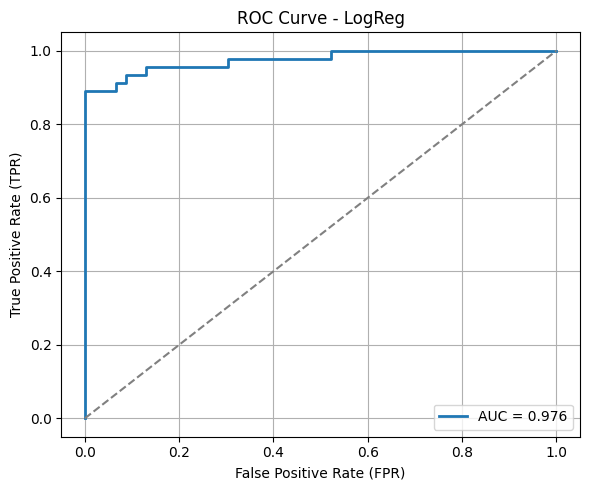

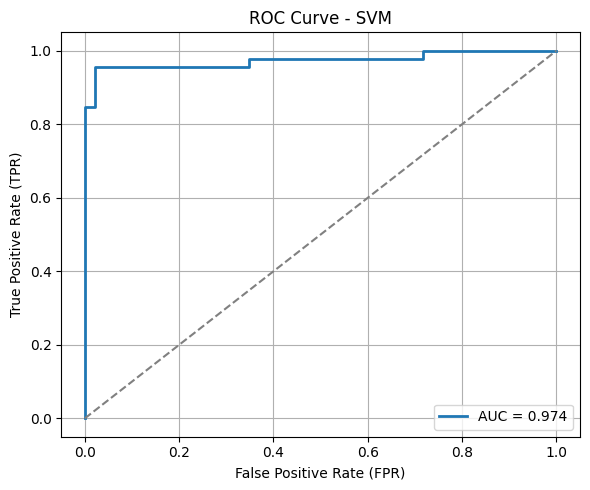

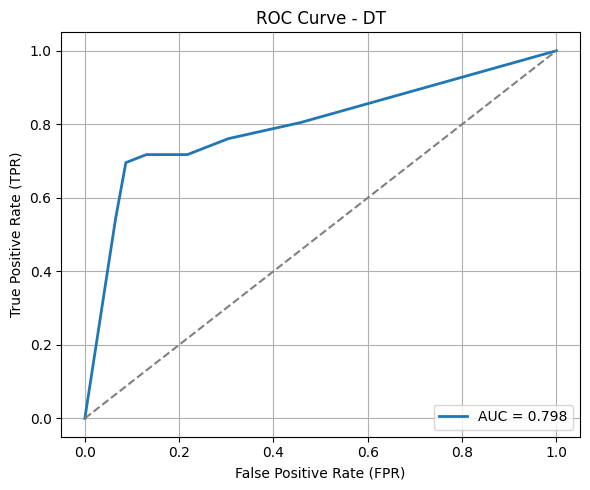

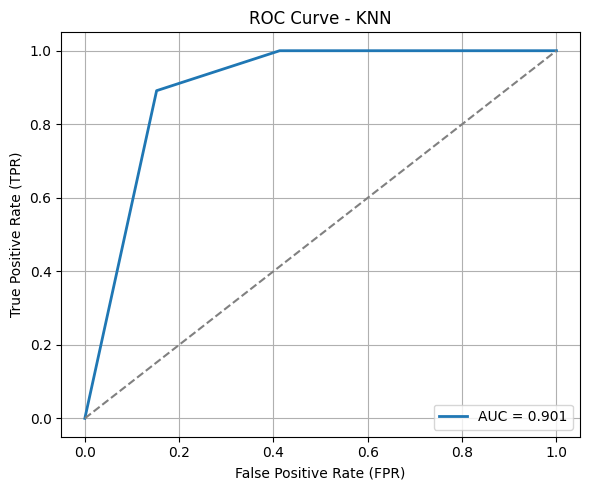


RESUMEN ROC / AUC (TEST)
| model   |   AUC |   TPR@FPR≈0.10 |   TPR@FPR≈0.20 |   TPR@FPR≈0.30 |
|:--------|------:|---------------:|---------------:|---------------:|
| LogReg  | 0.976 |          0.913 |          0.935 |          0.957 |
| SVM     | 0.974 |          0.848 |          0.957 |          0.957 |
| KNN     | 0.901 |          0.891 |          0.891 |          1     |
| DT      | 0.798 |          0.696 |          0.717 |          0.761 |


In [26]:
# ==========================================================
# 9. ROC y AUC por modelo (gráficas separadas + tabla resumen)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def get_scores_for_roc(model, X):
    """
    Obtiene scores continuos para ROC.
    - predict_proba si existe
    - decision_function si no
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        return model.decision_function(X)
    else:
        raise ValueError(f"{type(model).__name__} no soporta scores continuos")

roc_summary = []

for name, est in best_estimators.items():
    # Reentrenamos con TODO el training set
    est.fit(X_train, y_train)

    # Scores continuos
    y_score = get_scores_for_roc(est, X_test)

    # ROC + AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    auc = roc_auc_score(y_test, y_score)

    # Guardamos resumen (solo valores clave, no toda la curva)
    roc_summary.append({
        "model": name,
        "AUC": auc,
        "TPR@FPR≈0.10": tpr[np.argmin(np.abs(fpr - 0.10))],
        "TPR@FPR≈0.20": tpr[np.argmin(np.abs(fpr - 0.20))],
        "TPR@FPR≈0.30": tpr[np.argmin(np.abs(fpr - 0.30))]
    })

    # --------- Gráfica ROC individual ----------
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==========================================================
# Tabla resumen ROC / AUC
# ==========================================================
df_roc = (
    pd.DataFrame(roc_summary)
    .set_index("model")
    .round(3)
    .sort_values("AUC", ascending=False)
)

print("\nRESUMEN ROC / AUC (TEST)")
print(df_roc.to_markdown())




## Serializar y Guardar los distintos modelos

In [27]:
import joblib
import os

# Carpeta donde se guardarán los modelos
MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

# Guardamos cada modelo con un nombre claro
joblib.dump(best_estimators['LogReg'], os.path.join(MODELS_DIR, 'logreg_model.pkl'))
joblib.dump(best_estimators['SVM'],    os.path.join(MODELS_DIR, 'svm_model.pkl'))
joblib.dump(best_estimators['DT'],     os.path.join(MODELS_DIR, 'dt_model.pkl'))
joblib.dump(best_estimators['KNN'],    os.path.join(MODELS_DIR, 'knn_model.pkl'))

print("Modelos guardados correctamente:")
print(os.listdir(MODELS_DIR))


Modelos guardados correctamente:
['svm_model.pkl', 'logreg_model.pkl', 'knn_model.pkl', 'dt_model.pkl']


In [28]:
from google.colab import files

files.download('models/logreg_model.pkl')
files.download('models/svm_model.pkl')
files.download('models/dt_model.pkl')
files.download('models/knn_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prueba del Modelo con un audio (Por Hacer)

**USANDO EL ALGORITMO ENTRENADO:**  
Est a secci[on ofrece una interfaz de línea de comandos para predecir si un clip de tos es “Positive” o “Negative” para covid (etiqueta binaria) usando un modelo SVM previamente entrenado con características MFCC + ZCR.  

**Flujo principal:**  
1. **Parseo de argumentos**  
   - `--file`: ruta del audio (WAV, MP3, etc.)  
   - `--sex`: 0 (male/otro) o 1 (female)  
   - `--model`: archivo `.pkl` del modelo SVM  

2. **Carga del modelo**  
   - Valida existencia y carga con `joblib.load`.  

3. **Obtención del archivo de audio**  
   - Si no se pasa `--file`, permite subir en Colab o pide ruta local.  

7. **Salida de resultados**  
   - Muestra nombre de archivo, recuentos por segmento y porcentaje de confianza.  
   - Imprime mensaje final personalizado:  
     - Si etiqueta = 0 → “NO TIENES COVID!”  
     - Si etiqueta ≠ 0 → “SI TIENES COVID U.U”  


In [ ]:
"""
Inferencia de polaridad ('Positive'/'Negative') de un clip de voz
usando un modelo SVM entrenado con MFCC + ZCR.

✅ VERSIÓN SIMPLIFICADA - SOLO SUBIDA DE ARCHIVOS
-------------------------------------------------
1. Subir archivo de audio WAV
2. Extrae features con librosa
3. Ejecuta predicción con modelo SVM

Autor original: <tu nombre>
Última revisión: 29‑jun‑2025
"""

# ============================ Imports =======================================
import argparse
import os
import sys
from collections import Counter

import librosa
import numpy as np
import pandas as pd
from joblib import load

# ---------- Dependencias opcionales según entorno ----------
COLAB = False
try:
    import google.colab  # type: ignore
    from google.colab import files  # type: ignore
    COLAB = True
except ImportError:
    # Ejecución local
    pass

# ========================== 1. Pre‑procesamiento ============================

def normalize_audio(audio: np.ndarray) -> np.ndarray:
    """Normaliza a ±0.99 para evitar clipping."""
    peak = np.max(np.abs(audio)) + 1e-6
    return audio / peak * 0.99


def remove_silence(audio: np.ndarray, sr: int, top_db: int = 60) -> np.ndarray:
    """Elimina silencios usando librosa.effects.split."""
    intervals = librosa.effects.split(audio, top_db=top_db)
    return (
        np.concatenate([audio[s:e] for s, e in intervals])
        if intervals.size
        else audio
    )


def segment_audio(audio: np.ndarray, sr: int, duration: float = 1.5, hop: float = 0.75) -> list[np.ndarray]:
    """Ventanas deslizantes de `duration` s cada `hop` s."""
    fl, hl = int(duration * sr), int(hop * sr)
    return [audio[i : i + fl] for i in range(0, len(audio) - fl + 1, hl)]


def extract_features(segment: np.ndarray, sr: int) -> np.ndarray:
    """MFCC (128) + ZCR (1) → vector 129‑d."""
    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=128, n_fft=512, hop_length=256)
    zcr = librosa.feature.zero_crossing_rate(segment)
    return np.hstack([mfccs.mean(axis=1), zcr.mean()])

# ============================== 2. Modelo ====================================

def load_model(path: str):
    """Carga el modelo serializado con joblib/pickle."""
    if not os.path.isfile(path):
        sys.exit(f"⚠️  No existe el modelo: {path}")
    return load(path)

# ========================== 3. Audio helpers =================================

def upload_audio_colab() -> str:
    """Subir archivo de audio en Colab."""
    print("📁 Por favor, selecciona un archivo de audio WAV...")
    uploaded = files.upload()
    if not uploaded:
        sys.exit("⚠️  No se subió ningún archivo.")

    fname = next(iter(uploaded))
    if not fname.lower().endswith((".wav", ".mp3", ".m4a", ".flac")):
        print("⚠️ Formato no óptimo. Se recomienda WAV, pero se intentará procesar.")

    return fname

def get_audio_file_local() -> str:
    """Obtener archivo de audio en ejecución local."""
    while True:
        file_path = input("📁 Ruta del archivo de audio: ").strip()
        if os.path.isfile(file_path):
            return file_path
        print("⚠️ Archivo no encontrado. Intenta de nuevo.")

# =================== 4. Procesamiento de audio ===================

def process_audio_file(audio_path: str, sex: int) -> pd.DataFrame:
    """Procesa archivo de audio y extrae features."""
    print(f"🔊 Cargando audio: {audio_path}")

    # Cargar audio con librosa
    try:
        audio, sr = librosa.load(audio_path, sr=16_000)
        print(f"📊 Audio cargado: {len(audio)} samples a {sr} Hz ({len(audio)/sr:.2f} segundos)")
    except Exception as e:
        raise RuntimeError(f"❌ Error cargando audio: {e}")

    # Preprocessing
    audio = normalize_audio(audio)
    audio = remove_silence(audio, sr)

    if len(audio) < sr * 1.5:  # Menos de 1.5 segundos
        raise RuntimeError("⚠️ Audio muy corto después de quitar silencios")

    print(f"🔧 Audio procesado: {len(audio)/sr:.2f} segundos después de quitar silencios")

    # Segmentación
    segments = segment_audio(audio, sr)
    if not segments:
        raise RuntimeError("No se pudieron crear segmentos de audio")

    print(f"📊 Creados {len(segments)} segmentos para análisis")

    # Extracción de features
    features = []
    for i, segment in enumerate(segments):
        feat = extract_features(segment, sr)
        features.append(feat)
        if i < 3:  # Mostrar solo los primeros 3
            print(f"  Segmento {i+1}: MFCC promedio = {feat[:5].round(3)}")

    # Crear DataFrame
    df = pd.DataFrame(features, columns=[f"mfcc_{i}" for i in range(128)] + ["zcr"])
    df.insert(0, "sex", sex)
    df.insert(0, "filename", os.path.basename(audio_path))

    return df

def majority_vote(model, df_features: pd.DataFrame) -> tuple[str, Counter]:
    """Voto mayoritario sobre segmentos."""
    try:
        X = df_features[model.feature_names_in_]
    except AttributeError:
        X = df_features.drop(columns=["filename", "sex"], errors="ignore")

    preds = model.predict(X)
    tally = Counter(preds)
    return tally.most_common(1)[0][0], tally

# ====================== 5. CLI / argumentos =================================

def parse_args():
    ap = argparse.ArgumentParser(description="Inferencia sobre audio WAV")
    ap.add_argument("--file", help="Ruta del archivo de audio")
    ap.add_argument("--sex", choices=["0", "1"], help="0 = male/otro, 1 = female")
    ap.add_argument("--model", default="svm_model.pkl", help="Archivo del modelo SVM")
    args, _ = ap.parse_known_args()
    return args

# ========================== 6. Main =========================================

def main():
    args = parse_args()

    print("🤖 Cargando modelo SVM...")
    model = load_model(args.model)
    print("✅ Modelo cargado correctamente")

    # ---------- Obtener sexo ----------
    if args.sex is None:
        print("\n👤 Información del paciente:")
        while True:
            sex_input = input("Sexo (0 = masculino/otro, 1 = femenino): ").strip()
            if sex_input in ("0", "1"):
                args.sex = sex_input
                break
            print("⚠️ Por favor ingresa 0 ó 1")

    sex = int(args.sex)

    # ---------- Obtener archivo de audio ----------
    if args.file:
        # Archivo especificado por parámetro
        if not os.path.isfile(args.file):
            sys.exit(f"⚠️ Archivo no encontrado: {args.file}")
        audio_path = args.file
    else:
        # Obtener archivo según el entorno
        if COLAB:
            audio_path = upload_audio_colab()
        else:
            audio_path = get_audio_file_local()

    # ---------- Procesar audio ----------
    print(f"\n🔄 Procesando archivo: {audio_path}")
    df = process_audio_file(audio_path, sex)

    # ---------- Predicción ----------
    print("\n🧠 Ejecutando predicción...")
    final_label, counts = majority_vote(model, df)

    # ---------- Resultado ----------
    print("\n" + "=" * 60)
    print(f"📁 Archivo: {os.path.basename(audio_path)}")
    print(f"📊 Predicciones por segmento: {dict(counts)}")
    print(f"🎯 RESULTADO FINAL: {final_label}")
    if final_label == 0:
      print(f"🎯 RESULTADO FINAL: {final_label} – NO TIENES COVID!")
    else:
        print(f"🎯 RESULTADO FINAL: {final_label} – SI TIENES COVID U.U")
    print(f"📈 Confianza: {counts[final_label]}/{sum(counts.values())} segmentos")

    # Mostrar porcentaje de confianza
    confidence_pct = (counts[final_label] / sum(counts.values())) * 100
    print(f"💯 Porcentaje de segmentos: {confidence_pct:.1f}%")

    # Mostrar detalles por segmento si hay pocos
    if len(counts) <= 5:
        print("\n📋 Detalle por segmento:")
        for label, count in counts.most_common():
            pct = (count / sum(counts.values())) * 100
            print(f"  {label}: {count} segmentos ({pct:.1f}%)")

    print("=" * 60)


if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\n❌ Cancelado por el usuario")
        sys.exit(0)
    except Exception as e:
        print(f"\n💥 Error: {e}")
        sys.exit(1)

🤖 Cargando modelo SVM...
✅ Modelo cargado correctamente

👤 Información del paciente:
Sexo (0 = masculino/otro, 1 = femenino): 0
📁 Por favor, selecciona un archivo de audio WAV...


Saving 179_Positive_male_25.wav to 179_Positive_male_25.wav

🔄 Procesando archivo: 179_Positive_male_25.wav
🔊 Cargando audio: 179_Positive_male_25.wav
📊 Audio cargado: 98304 samples a 16000 Hz (6.14 segundos)
🔧 Audio procesado: 5.86 segundos después de quitar silencios
📊 Creados 6 segmentos para análisis
  Segmento 1: MFCC promedio = [-459.693   89.929  -13.312   10.389   -9.594]
  Segmento 2: MFCC promedio = [-483.239   91.918   -5.656    5.673   -8.652]
  Segmento 3: MFCC promedio = [-527.178   99.269  -11.375   -2.381   -9.091]

🧠 Ejecutando predicción...

📁 Archivo: 179_Positive_male_25.wav
📊 Predicciones por segmento: {np.int64(1): 6}
🎯 RESULTADO FINAL: 1
🎯 RESULTADO FINAL: 1 – SI TIENES COVID U.U
📈 Confianza: 6/6 segmentos
💯 Porcentaje de segmentos: 100.0%

📋 Detalle por segmento:
  1: 6 segmentos (100.0%)
